In [4]:
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [45]:
class Value:
    def __init__(self, data, _children=(), _op='', label=''):
        """
        Initialize data, set of children (for operation graph)
        """
        self.data = data
        self.grad = 0.0
        self._backward = lambda: None
        self._prev = set(_children)
        self._op = _op
        self.label = label
    
    def __repr__(self):
        return f"(data={self.data})"
    
    def __add__(self, other):
        """
        Do the specified operation, update set of children
        """
        out = Value(self.data + other.data, _children = (self, other), _op = '+')
        def _backward():
            self.grad = 1.0 * out.grad
            other.grad = 1.0 * out.grad
            self._backward()
            other._backward()
        out._backward = _backward
        return out
    
    def __mul__(self, other):
        out = Value(self.data * other.data, _children = (self, other), _op = '*')
        def _backward():
            self.grad = other.data * out.grad
            other.grad = self.data * out.grad
            self._backward()
            other._backward()
        out._backward = _backward
        return out
    
    def tanh(self):
        x = self.data
        t = (math.exp(2 * x) - 1) / (math.exp(2 * x) + 1)
        def _backward():
            self.grad = (1 - t ** 2) * out.grad
            self.is_leaf: self._backward()
        out._backward = _backward
        out = Value(t, (self,), 'tanh')
    
a = Value(2.0, label='a')
b = Value(-3.0, label='b')
c = Value(10.0, label='c')
e = a * b; e.label = 'e'
d = e + c; d.label = 'd'
f = Value(-2.0, label='f')
L = d * f
L.grad = 1.0
L

(data=-8.0)

In [ ]:
# Without recursive call to _backward()

In [35]:
L._backward()

In [27]:
d.grad, f.grad

(-2.0, 4.0)

In [28]:
e.grad

0.0

In [29]:
d._backward()

In [30]:
e.grad, c.grad

(-2.0, -2.0)

In [ ]:
# Try recursive call to _backward()

In [46]:
L._backward()

In [47]:
d.grad, f.grad

(-2.0, 4.0)

In [48]:
e.grad, c.grad

(-2.0, -2.0)

In [ ]:
# WORKS!! But I do think the tensor version can't afford to update each node through
# each of its parent nodes, individually.

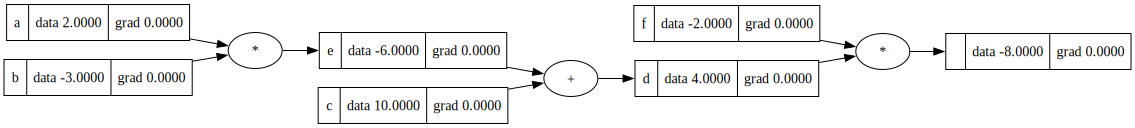

In [21]:
from graphviz import Digraph

def trace(root):
    """
    Traces the operation graph that produces this variable
    """
    nodes, edges = set(), set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)
    build(root)
    return nodes, edges

def draw_dot(root):
    dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'})

    nodes, edges = trace(root)
    for n in nodes:
        uid = str(id(n))
        dot.node(name = uid, label = "{ %s | data %.4f | grad %.4f}" % (n.label, n.data, n.grad), shape = 'record')
        if n._op:
            dot.node(name = uid + n._op, label = n._op)
            dot.edge(uid + n._op, uid)
    for n1, n2 in edges:
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)
    return dot

trace(L)
draw_dot(L)

In [40]:
class Value:
    def __init__(self, data, _children=(), _op='', label=''):
        """
        Initialize data, set of children (for operation graph)
        """
        self.data = data
        self.grad = 0.0
        self._backward = lambda: None
        self._prev = set(_children)
        self._op = _op
        self.label = label
    
    def __repr__(self):
        return f"(data={self.data})"
    
    def __add__(self, other):
        """
        Do the specified operation, update set of children
        """
        out = Value(self.data + other.data, _children = (self, other), _op = '+')
        def _backward():
            self.grad = 1.0 * out.grad
            other.grad = 1.0 * out.grad
        out._backward = _backward
        return out
    
    def __mul__(self, other):
        out = Value(self.data * other.data, _children = (self, other), _op = '*')
        def _backward():
            self.grad = other.data * out.grad
            other.grad = self.data * out.grad
        out._backward = _backward
        return out
    
    def tanh(self):
        x = self.data
        t = (math.exp(2 * x) - 1) / (math.exp(2 * x) + 1)
        def _backward():
            self.grad = (1 - t ** 2) * out.grad
        out._backward = _backward
        out = Value(t, (self,), 'tanh')
    
a = Value(2.0, label='a')
b = Value(-3.0, label='b')
c = Value(10.0, label='c')
e = a * b; e.label = 'e'
d = e + c; d.label = 'd'
f = Value(-2.0, label='f')
L = d * f
L.grad = 1.0
L

(data=-8.0)

In [49]:
# Now do the topological sort version
L.grad = 1.0

topo = []
visited = set()
def build_topo(v):
    if v not in visited:
        visited.add(v)
        for child in v._prev:
            build_topo(child)
        topo.append(v)
build_topo(L)

for node in reversed(topo):
    node._backward()

In [50]:
L.grad

1.0

In [51]:
d.grad, f.grad

(-2.0, 4.0)

In [52]:
e.grad, c.grad

(-2.0, -2.0)

In [57]:
# "Hide" topological sort backward in the Value class
class Value:
    def __init__(self, data, _children=(), _op='', label=''):
        """
        Initialize data, set of children (for operation graph)
        """
        self.data = data
        self.grad = 0.0
        self._backward = lambda: None
        self._prev = set(_children)
        self._op = _op
        self.label = label
    
    def __repr__(self):
        return f"(data={self.data})"
    
    def __add__(self, other):
        """
        Do the specified operation, update set of children
        """
        out = Value(self.data + other.data, _children = (self, other), _op = '+')
        def _backward():
            self.grad = 1.0 * out.grad
            other.grad = 1.0 * out.grad
        out._backward = _backward
        return out
    
    def __mul__(self, other):
        out = Value(self.data * other.data, _children = (self, other), _op = '*')
        def _backward():
            self.grad = other.data * out.grad
            other.grad = self.data * out.grad
        out._backward = _backward
        return out
    
    def tanh(self):
        x = self.data
        t = (math.exp(2 * x) - 1) / (math.exp(2 * x) + 1)
        def _backward():
            self.grad = (1 - t ** 2) * out.grad
        out._backward = _backward
        out = Value(t, (self,), 'tanh')

    def backward(self):
        """
        Runs full backpropagation starting at self. Only to be used if this is the root (loss) node.
        """
        topo = []
        visited = set()

        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)
        build_topo(self)
        
        self.grad = 1.0
        for node in reversed(topo):
            node._backward()

a = Value(2.0, label='a')
b = Value(-3.0, label='b')
c = Value(10.0, label='c')
e = a * b; e.label = 'e'
d = e + c; d.label = 'd'
f = Value(-2.0, label='f')
L = d * f
L.grad = 1.0
L

(data=-8.0)

In [58]:
L.backward()

In [59]:
L.grad

1.0

In [60]:
d.grad, f.grad

(-2.0, 4.0)

In [61]:
e.grad, c.grad

(-2.0, -2.0)

Backpropogation for when the same node is used multiple times

In [142]:
class Value:
    def __init__(self, data, _children=(), _op='', label=''):
        """
        Initialize data, set of children (for operation graph)
        """
        self.data = data
        self.grad = 0.0
        self._backward = lambda: None
        self._prev = set(_children)
        self._op = _op
        self.label = label
    
    def __repr__(self):
        return f"Value(data={self.data})"
    
    def __add__(self, other):
        """
        Do the specified operation, update set of children
        """
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data + other.data, _children = (self, other), _op = '+')
        def _backward():
            self.grad += 1.0 * out.grad
            other.grad += 1.0 * out.grad
        out._backward = _backward
        return out
    
    def __radd__(self, other):
        return self + other
    
    def __sub__(self, other):
        """
        Do the specified operation, update set of children
        """
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data - other.data, _children = (self, other), _op = '-')
        def _backward():
            self.grad += 1.0 * out.grad
            other.grad += -1.0 * out.grad
        out._backward = _backward
        return out
    
    def __rsub__(self, other):
        # Probably works, not really tested.
        return -1.0 * self + other
    
    def __mul__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data * other.data, _children = (self, other), _op = '*')
        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad
        out._backward = _backward
        return out
    
    def __rmul__(self, other):
        """
        In case we have a float * Value situation, the float won't know how to multiply, so it
        will ask our Value how to do it.
        """
        return self * other
    
    def __pow__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data ** other.data, _children = (self, other), _op = '**')
        def _backward():
            self.grad += (self.data ** other.data * math.log(self.data)) * out.grad
            other.grad += (other.data * self.data ** (other.data - 1)) * out.grad
        out._backward = _backward
        return out
    
    def __rpow__(self, other):
        # Not sure if this is really possible lol
        pass
    
    def tanh(self):
        x = self.data
        t = (math.exp(2 * x) - 1) / (math.exp(2 * x) + 1)
        def _backward():
            self.grad += (1 - t ** 2) * out.grad
        out = Value(t, (self,), 'tanh')
        out._backward = _backward
        return out

    def backward(self):
        """
        Runs full backpropagation starting at self. Only to be used if this is the root (loss) node.
        """
        topo = []
        visited = set()

        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)
        build_topo(self)
        
        self.grad = 1.0
        for node in reversed(topo):
            node._backward()

a = Value(2.0, label='a')
b = Value(-3.0, label='b')
c = Value(10.0, label='c')
e = a * b; e.label = 'e'
d = e + c; d.label = 'd'
f = Value(-2.0, label='f')
L = d * f
L.grad = 1.0
L

Value(data=-8.0)

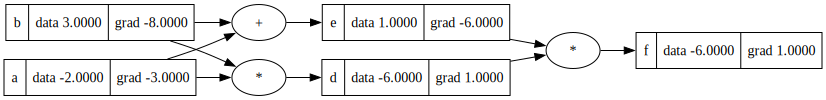

In [63]:
a = Value(-2.0, label='a')
b = Value(3.0, label='b')
d = a * b; d.label = 'd'
e = a + b; e.label = 'e'
f = d * e; f.label = 'f'

f.backward()
draw_dot(f)

In [68]:
# inputs x1, x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')

# weights w1, w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')

# bias of the neuron
b = Value(6.8813735870195432, label='b')

# x1*w1 + x2*w2 + b
x1w1 = x1 * w1; x1w1.label = 'x1*w1'
x2w2 = x2 * w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'
o = n.tanh(); o.label = 'o'

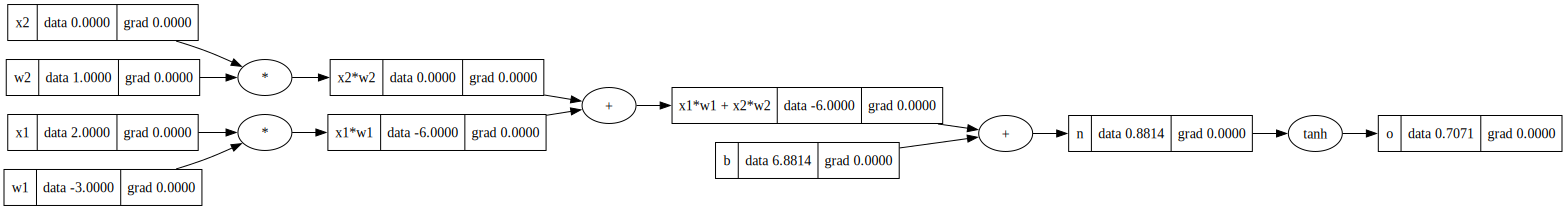

In [69]:
draw_dot(o)

Doing backpropagation with PyTorch!

In [70]:
import torch

In [72]:
x1 = torch.Tensor([2.0]).double(); x1.requires_grad = True
x2 = torch.Tensor([0.0]).double(); x2.requires_grad = True
w1 = torch.Tensor([-3.0]).double(); w1.requires_grad = True
w2 = torch.Tensor([1.0]).double(); w2.requires_grad = True
b = torch.Tensor([6.8813735870195432]).double(); b.requires_grad = True

# Compute the output
n = x1*w1 + x2*w2 + b
o = torch.tanh(n)

# Print output and gradients
print(o.data.item())
o.backward()

print('---')
print('x2', x2.grad.item())
print('w2', w2.grad.item())
print('x1', x1.grad.item())
print('w1', w1.grad.item())

0.7071066904050358
---
x2 0.5000001283844369
w2 0.0
x1 -1.5000003851533106
w1 1.0000002567688737


In [75]:
import random

In [145]:
class Neuron:
    def __init__(self, nin):
        self.w = [Value(random.uniform(-1, 1)) for _ in range(nin)]
        self.b = Value(random.uniform(-1, 1))
    
    def __call__(self, x):
        act = sum([wi * xi for wi, xi in zip(self.w, x)]) + b
        out = act.tanh()
        return out
    
    def parameters(self):
        return self.w + [self.b]

class Layer:
    def __init__(self, nin, nout):
        self.neurons = [Neuron(nin) for _ in range(nout)]
    
    def __call__(self, x):
        out = [neuron(x) for neuron in self.neurons]
        return out if len(self.neurons) > 1 else out[0]
    
    def parameters(self):
        return [p for neuron in self.neurons for p in neuron.parameters()]
        

class MLP:
    def __init__(self, nin, nouts):
        sz = [nin] + nouts
        self.layers = [Layer(sz[i], sz[i + 1]) for i in range(len(sz) - 1)]
    
    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        return x
    
    def parameters(self):
        return [p for layer in self.layers for p in layer.parameters()]

x = [2.0, 3.0, -1.0]
n = MLP(3, [1])
n(x)

Value(data=-0.8866678036569775)

In [140]:
# Input data
xs = [
    [2.0, 3.0, -1.0],
    [3.0, -1.0, 0.5],
    [0.5, 1.0, 1.0],
    [1.0, 1.0, -1.0],
]

# Desired targets
ys = [1.0, -1.0, -1.0, 1.0]

# Predictions
ypred = [n(x) for x in xs]
ypred

[Value(data=-0.9986204209256039),
 Value(data=-0.9796660529190829),
 Value(data=-0.9953525295067994),
 Value(data=-0.9971257866571689)]

One iteration of learning

In [171]:
n = MLP(3, [1])
n.parameters()

[Value(data=0.02381629577251232),
 Value(data=-0.7773340960012409),
 Value(data=-0.35589256073972586),
 Value(data=-0.8551272022287117)]

In [172]:
# forward pass
ypred = [n(x) for x in xs]
loss = sum((yout - ygt) * (yout - ygt) for ygt, yout in zip(ys, ypred))
# backward pass
for p in n.parameters():
    p.grad = 0.0
loss.backward()
# Update
for p in n.parameters():
    p.data += -0.01 * p.grad

In [173]:
n.parameters()

[Value(data=0.023969548309018436),
 Value(data=-0.7771165305052395),
 Value(data=-0.3560863965471345),
 Value(data=-0.8551272022287117)]

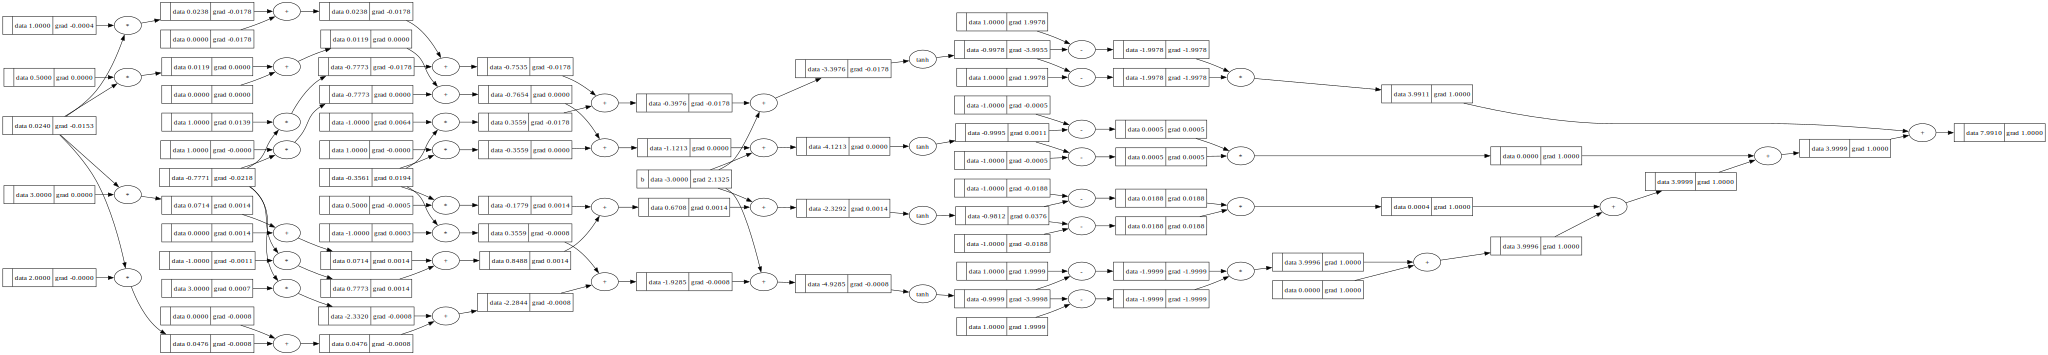

In [174]:
draw_dot(loss)